# Time Series Modelling & Stock Forecasting - using ARIMA Models

### Loading and Studying the Data - 

In [315]:
# Importing and Loading all the necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import datetime as datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
plt.style.use('fivethirtyeight')  # defining a matplotlib style of fivethirtyeight for plots
import itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics

In [250]:
# Importing the data from Kaggle as a csv file and converting it into a Pandas DataFrame:
amazon_data = pd.read_csv('Amazon.csv')

# Viewing the snapshot of first 5 rows of the loaded dataset:
amazon_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [251]:
# Getting the basic information about the dataset:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5852 non-null   object 
 1   Open       5852 non-null   float64
 2   High       5852 non-null   float64
 3   Low        5852 non-null   float64
 4   Close      5852 non-null   float64
 5   Adj Close  5852 non-null   float64
 6   Volume     5852 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 320.2+ KB


In [252]:
# Checking the size of dataset - total rows and columns:
amazon_data.shape

(5852, 7)

In [253]:
# Getting a statistical summary of the dataset (rounded to 2 decimals):
amazon_data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,5852.00,5852.00,5852.00,5852.00,5852.00,5.852000e+03
mean,377.47,381.74,372.82,377.50,377.50,7.512673e+06
std,596.29,602.62,589.23,596.29,596.29,7.278144e+06
min,1.41,1.45,1.31,1.40,1.40,4.872000e+05
25%,37.99,38.59,37.25,37.95,37.95,3.681975e+06
50%,83.70,85.03,82.06,83.60,83.60,5.652850e+06
75%,360.85,365.79,357.88,362.22,362.22,8.517450e+06
max,3251.06,3344.29,3165.43,3225.00,3225.00,1.043292e+08


There are multiple variables in the dataset – Date, Open, High, Low, Close and volume.

* Open and Close - The starting and final price at which the stock is traded on a particular day.

* Adj Close - The closing or final price of the stock adjusted for corporate actions like stock splits and dividends.

* High and Low - The maximum and minimum price of the share for the day.

* Volume - The number of shares bought or sold in the day

As the Date column is in Object data type it needs to be converted to date time format types before making any Time series analysis.

### Data Cleaning and Formatting -

#### Changing Data Types:

In [254]:
# Converting the Date column from Object data type to Datetime64 format:
amazon_data.Date = pd.to_datetime(amazon_data.Date)

# Getting the basic information after dtype change:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5852 non-null   datetime64[ns]
 1   Open       5852 non-null   float64       
 2   High       5852 non-null   float64       
 3   Low        5852 non-null   float64       
 4   Close      5852 non-null   float64       
 5   Adj Close  5852 non-null   float64       
 6   Volume     5852 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 320.2 KB


#### Missing Values Detection:

In [255]:
# Getting the sum count of missing values in each column:
amazon_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

The above output shows that this dataset had no missing values in any column, so requires no imputations.

#### Feature Enginnering:

We used different instance methods in the Datetime module to strip or parse the date column features and create separate columns from them like for Year, Month Name, Day Name etc. This would be used in further EDA analysis on the dataset.

In [256]:
# adding a few more columns to our dataset -  containing the year, month name, and weekday name
amazon_data['Year'] = pd.DatetimeIndex(amazon_data['Date']).year
amazon_data['Month'] = pd.DatetimeIndex(amazon_data['Date']).month_name()
amazon_data['Weekday'] = pd.DatetimeIndex(amazon_data['Date']).day_name()  # day_name is a function in pandas

# setting the Date column as index for the dataset:
amazon_data.set_index('Date',inplace=True)

# getting a snapshot of first 5 rows of dataset:
amazon_data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Weekday
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1997,May,Thursday
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1997,May,Friday
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1997,May,Monday
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1997,May,Tuesday
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1997,May,Wednesday


### Exploratory Data Analysis (EDA) -

Now, that we have our dataset cleaned and formatted let us carry out some basic Exploratory data analysis on our Amazon stock dataset. Below we try to explore our dataset by asking some questions:- 

##### What’s the change in Amazon’s Price and Volume over time?

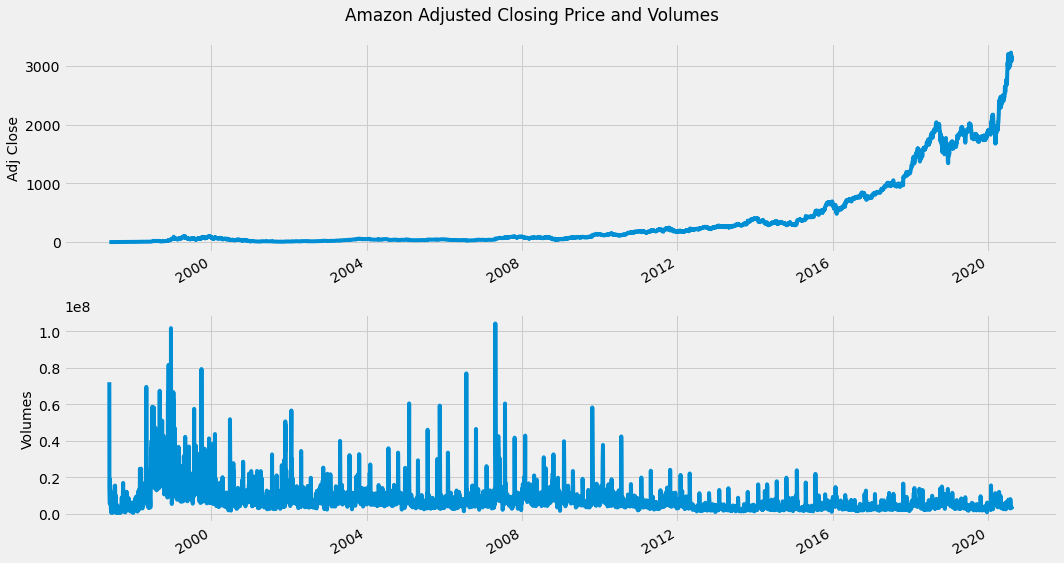

In [257]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plotting Amazon's adjusted closing price as a line plot:
amazon_data['Adj Close'].plot(ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Adj Close',fontsize=14)

# Creating a line plot for Amazon's stock Volumes:
amazon_data['Volume'].plot(ax=axes[1])
axes[1].set_ylabel('Volumes', fontsize=14)
axes[1].set_xlabel('')  # to get nothing in x axis as labels

plt.suptitle('Amazon Adjusted Closing Price and Volumes')
plt.tight_layout()
plt.show()

Amazon Close prices show very steep rise during the period after 2016 however, its volume have declined from 2000 or 2008 levels when they were at peak.

##### What’s the Moving Average for Amazon stock ?

Moving average of a stock helps to smoothen out the price data from the impacts of random, short-term fluctuations on the price of a stock over a specified time period. This is done by creating and constantly updating the stock's average price. 

The longer the time period for the moving average, the greater the lag. So, a 200-day moving average will have a much greater degree of lag than a 20-day MA because it contains prices for the past 200 days. 

The 50-day and 200-day moving average figures for stocks are widely followed by investors and traders and are considered to be important **trading signals**.

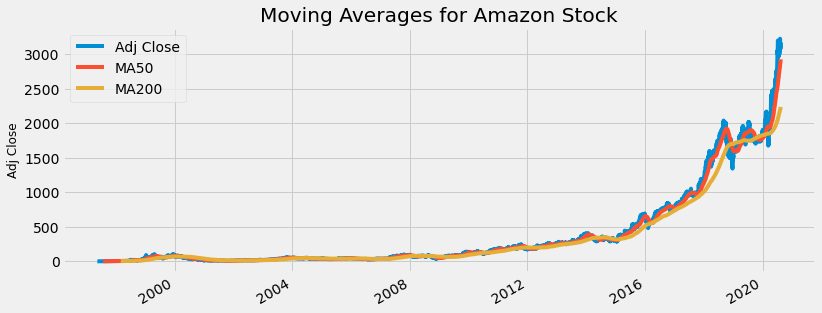

In [258]:
# Calculating the 50-day and 200-day Moving Average for Amazon stock:
amazon_data['MA50'] = amazon_data['Adj Close'].rolling(50).mean()
amazon_data['MA200'] = amazon_data['Adj Close'].rolling(200).mean()
amazon_data['Adj Close'].plot(figsize = (12,5))
amazon_data['MA50'].plot()
amazon_data['MA200'].plot()
plt.xlabel('')
plt.ylabel('Adj Close', fontsize=12)
plt.title('Moving Averages for Amazon Stock')
plt.legend()
plt.show()

Both the 50-day and 200-day Moving Average for Amazon Adjusted Close price show a fairly smoothed but rising in Daily adjusted closing price.

##### What’s the Daily Average Return for Amazon Stock?

A percentage change (increase or decrease) in stock value compared to that the previous day. The bigger the value either positive or negative the more volatile a stock is.

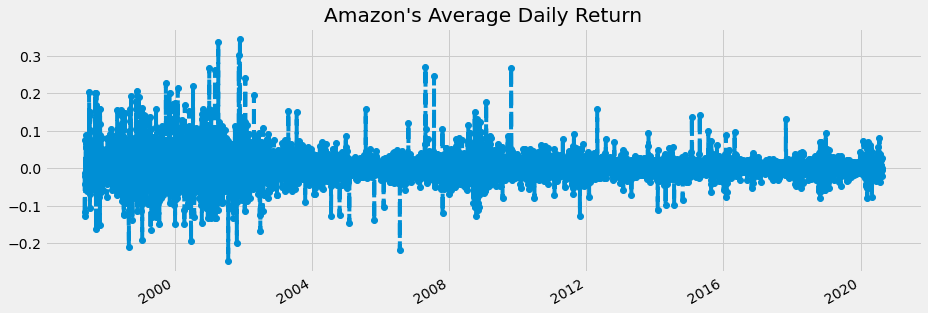

In [259]:
# Calculating the returns for Amazon stock using the percent change or pct_change() function:
amazon_data['returns'] = amazon_data['Adj Close'].pct_change()
amazon_data['returns'].plot(figsize=(14,5),linestyle='--',marker='o')
plt.xlabel('')
plt.title("Amazon's Average Daily Return")
plt.show()

The movements in Amazon stock have reduced over time as we can see small percentage change (increase or decrease) in stock value 2016 onwards compared to that in the 2000s.

##### Interactive Plot of Low-High of Amazon Stocks -

In [260]:
# Plotting Daily High and Low prices for Amazon using Plotly -
# installed plotly using ----> conda install -c plotly plotly=5.5.0
import plotly.express as px

fig = px.line(amazon_data, x=amazon_data.index, y=["High", "Low"], title='Daily High & Low for Amazon Stocks')
fig.update_layout(title=dict(text="Daily High-Low for Amazon Stocks",font=dict(size=18)))
fig.show()

Above plot shows a steep rise in Amazon's daily stock prices both High and Low throughout the period till 2020.

##### Visualizing Movements in Amazon Volumes by Weekdays and by Months - 

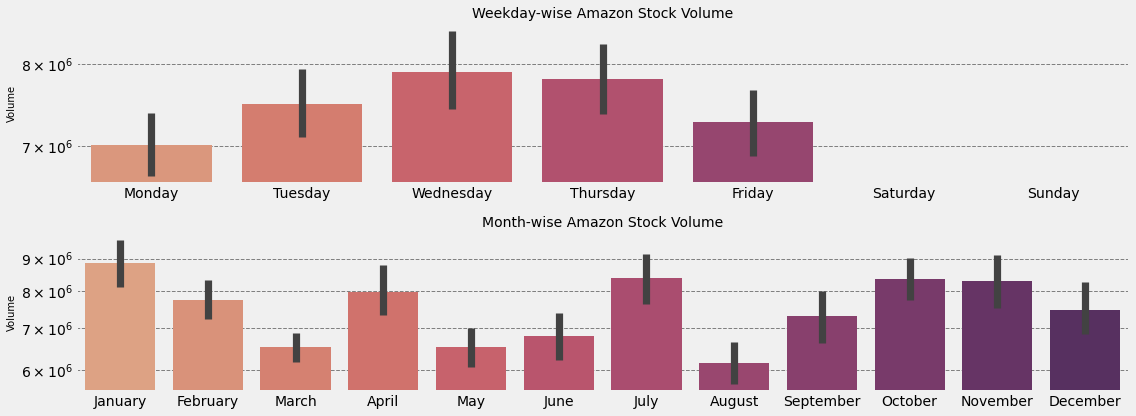

In [261]:
# Visualizing Movements in Amazon Volumes by Weekdays and by Months as Bar Subplots- 
fig, axes = plt.subplots(2, 1, figsize=(16, 6))

# specifying the order of bar plots for weekdays:
order = [ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
sns.barplot(x=amazon_data.Weekday, y=amazon_data.Volume, palette="flare",ax=axes[0], order =order)
axes[0].set_title("Weekday-wise Amazon Stock Volume",fontsize=14)
axes[0].set_yscale("log") 
axes[0].set_ylabel("Volume",fontsize=10)
axes[0].set_xlabel("",fontsize=10)
axes[0].grid(which="minor",color="grey", linestyle="--")

# specifying the order of bar plots for Months:
order2 = [ "January", "February", "March", "April", "May", "June","July", 'August', 'September', 'October', 'November', 'December']
sns.barplot(x=amazon_data.Month, y=amazon_data.Volume, palette="flare",ax=axes[1], order = order2)
axes[1].set_title("Month-wise Amazon Stock Volume",fontsize=14)
axes[1].set_yscale("log")
axes[1].set_ylabel("Volume",fontsize=10)
axes[1].set_xlabel("",fontsize=10)
axes[1].grid(which="minor",color="grey", linestyle="--")

plt.tight_layout()
plt.show()

Amazon stock volumes appear to be the largest on Wednesday and Thursday while almost Nil on weekends (Saturday, Sunday). This is due to no trading on weekends. Also the January appears to be the highest month for trades in Amazon stocks followed by July, october and November compared to August which has the lowest. 

#####  Plotting the Mean of Amazon Daily Closing Price at the Start of every Year -

Using Resampling and Converting Frequencies

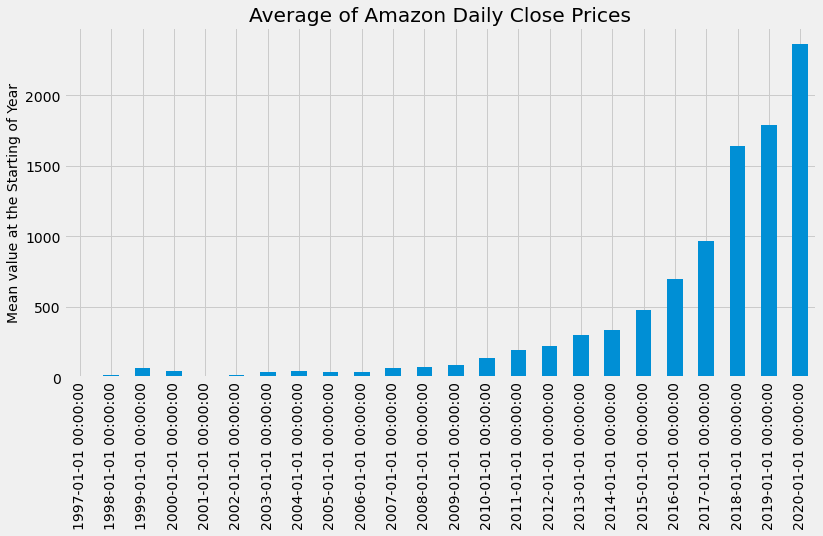

In [262]:
# First, creating a copy of amazon dataset:
rolling_amazon = amazon_data.copy()

# Plotting a bar for the mean of starting of every year for Amazon stock - 
ax = rolling_amazon.Close.resample(rule='AS').mean().plot.bar(figsize=(12,6))

# setting the title for the plot:
ax.set(title='Average of Amazon Daily Close Prices')
plt.ylabel('Mean value at the Starting of Year',size=14)
plt.xlabel('')
plt.show()

Amazon's daily closing price has tremendously increased over the years if we compare the average value at the start of every year only.

#### Exploring the Correlation between Different Amazon Daily Prices - 

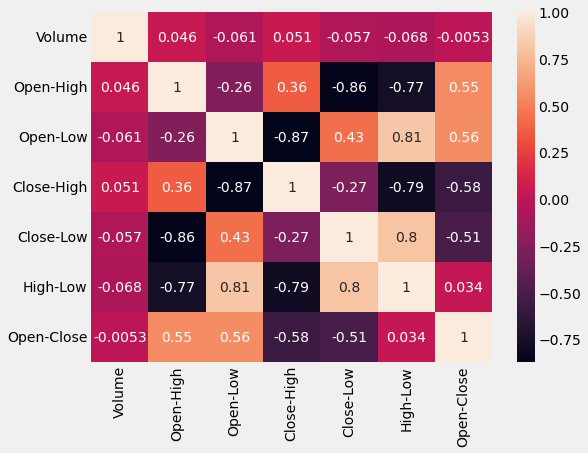

In [263]:
# firstly, we crete a copy of the Amazon datasset:
amazon_corr_df = amazon_data.copy()
amazon_corr_df.reset_index(inplace=True)

# Feature engineering - adding new columns to the new dataset created:
amazon_corr_df['Open-High'] = amazon_corr_df['Open']-amazon_corr_df['High']
amazon_corr_df['Open-Low'] = amazon_corr_df['Open'] - amazon_corr_df['Low']
amazon_corr_df['Close-High'] = amazon_corr_df['Close']-amazon_corr_df['High']
amazon_corr_df['Close-Low'] = amazon_corr_df['Close'] - amazon_corr_df['Low']
amazon_corr_df['High-Low'] = amazon_corr_df['High'] - amazon_corr_df['Low']
amazon_corr_df['Open-Close'] = amazon_corr_df['Open'] - amazon_corr_df['Close']

# Creating a heatmap to visualize the correlation among different Daily price columns for Amazon stocks:
amazon_corr_df2 = amazon_corr_df.copy()
amazon_corr_df2 = amazon_corr_df2.drop(['Open','High','Low','Close', 'Adj Close','Year', 'Month', 'Weekday','MA50', 'MA200', 'returns'],axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(amazon_corr_df2.corr(),annot=True)
plt.show()

Variables having a large correlation value with volume represent that those numbers might have intrigued a large number of buyers and sellers.  Correlation between those features and the volume feature will tell us how a change in that feature impacts the number of stocks traded that day.

The **Close-High** feature shows the maximum positive correlation with the **Volume** feature. Thus we can say that if the Amazon Closing price stays away from High value, it may lead to more transactions or trading volumes that day for the stock.

### Slicing Amazon Stock Data for Forecasting - 

* For ease of Stock Forecasting, henceforth we would only be using Amazon Stock price data from the Year **2015 onwards**. 
* Also, we would be using only the **Adjusted Close** and **Date** columns of our Amazon time series for training different Stock Forecasting techniques or algorithms andmaking predictions.

In [316]:
# Slicing stock data from 2015 onwards:
amazon_df = amazon_data[amazon_data['Year'] >= 2015]
amazon_df.shape

(1415, 12)

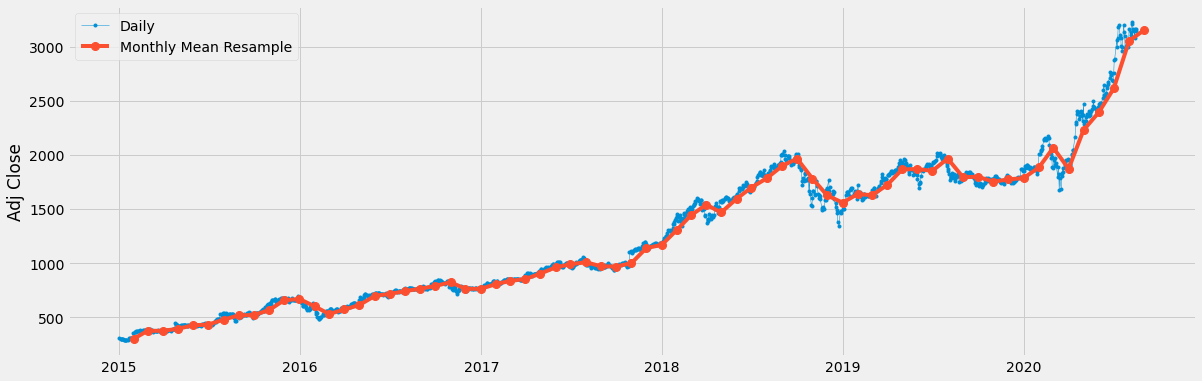

In [265]:
# Visualizing the Daily Adjusted Close and the Monthly Average resampled data for Amazon:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(amazon_df['Adj Close'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(amazon_df['Adj Close'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend()
plt.show()

From the plot above, we can see a general increasing trend in Amazon stock with no clear pattern of seasonal or cyclical changes. We will decompose the time series in the further steps to get details about seasonality.

### Testing for Stationarity - 

Time Series analysis only works with stationary data therefore before fitting any model, we need to check whether our Amazon time series is stationary or not. A time series is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time. We need to make it stationary if it is not.

Testing for Stationarity can be done using one or more of the following methods:-

#### Visualizing Rolling Statistics:

One of the more popular rolling statistics is the moving average. This takes a moving window of time, and calculates the average or the mean of that time period as the current value. 

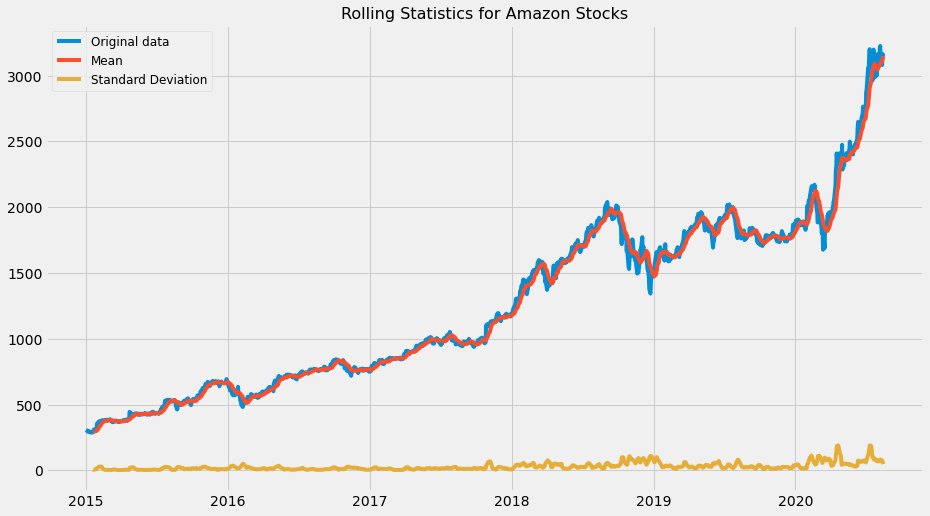

In [266]:
# Determining the rolling statistics for Amazon time series -
amazon = amazon_df['Adj Close']

# calculating the rolling mean and standard deviation with window sizes of 12: 
roll_mean = amazon.rolling(12).mean() 
roll_std = amazon.rolling(12).std()

# plotting the rolling statistics alongwith the original data for Amazon stock: 
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(amazon_df['Adj Close'], label= 'Original data')
ax.plot(roll_mean, label='Mean')
ax.plot(roll_std, label='Standard Deviation')
plt.title('Rolling Statistics for Amazon Stocks', fontsize=16)
ax.legend(fontsize=12)
plt.show()

Moving Standard Deviation is a statistical measurement of market volatility. The rolling standard deviation plot appears to be quite smooth in the beginning (2015-17 end) but becomes little volatile after 2018. In 2019 and end of 2020 there are some large movements. The rolling mean fits the original data for Amazon Adjusted Close quite closely.

By visualizing the rolling statistics (mean and variance) for Amazon Adjusted Close price above, we can see that there is some movement in both the mean and standard deviation but we cannot conclude anything about stationarity just by plotting. Therefore, we perform another test of stationarity.

#### Performing Augmented Dicky-Fuller (ADF) Test:

By performing ADF test we make run a test for statistical significance to determine whether our data is staionary or not, with different levels of confidence.

In [267]:
# Running the adfuller() function on Adj. Close of Amazon stock and assigning the result to result variable:
result = adfuller(amazon_df['Adj Close'])

# Printing the test statistic, the p-value and the critical values:
# manually specifying the statistics using a for loop:
output = pd.Series(result[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in result[4].items():
    output['critical value (%s)'%key] =  values
print(output)

# Printing a statement about accepting or rejecting the Null hypothesis by comparing the p-value with the critical values:
if output[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis, indicating Data is non-stationary.")

Test Statistics                   1.227091
p-value                           0.996168
No. of lags used                 18.000000
Number of observations used    1396.000000
critical value (1%)              -3.435043
critical value (5%)              -2.863613
critical value (10%)             -2.567873
dtype: float64
Weak evidence against null hypothesis, indicating Data is non-stationary.


We can see from the results above that our Test statistic was a positive value and our p-value > 0.05.  Additionally, the test statistics exceeded the critical values hence, the data was nonlinear. We did not reject our null hypothesis, and realized that Amazon time series was non-stationary. 

### Making our Time Series Stationary - 

As we discussed earlier, to proceed with our time series analysis using models, we need to stationarize our Amazon stock dataset. Here, we have used two methods to make the Amazon stock data stationary, detrending and differencing.

##### Method 1 - De-trending:

This method removes the underlying trend in the time series.

In [268]:
# Detrending the Amazon data:
amazon_detrend =  (amazon - amazon.rolling(12).mean()) / amazon.rolling(12).std()
detrend_result = adfuller(amazon_detrend.dropna())

# Printing the ADF test statistic, the p-value and the critical values on de-trended stock data:
# manually specifying the statistics using a for loop:
output_detrend = pd.Series(detrend_result[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key, values in detrend_result[4].items():
    output_detrend['critical value (%s)'%key] =  values
    
print(output_detrend)

# Printing a statement about accepting or rejecting the Null hypothesis by comparing the p-value with the critical values:
if output_detrend[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis, indicating Data is non-stationary.")

Test Statistics               -1.273046e+01
p-value                        9.400040e-24
No. of lags used               2.000000e+00
Number of observations used    1.401000e+03
critical value (1%)           -3.435026e+00
critical value (5%)           -2.863605e+00
critical value (10%)          -2.567870e+00
dtype: float64
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


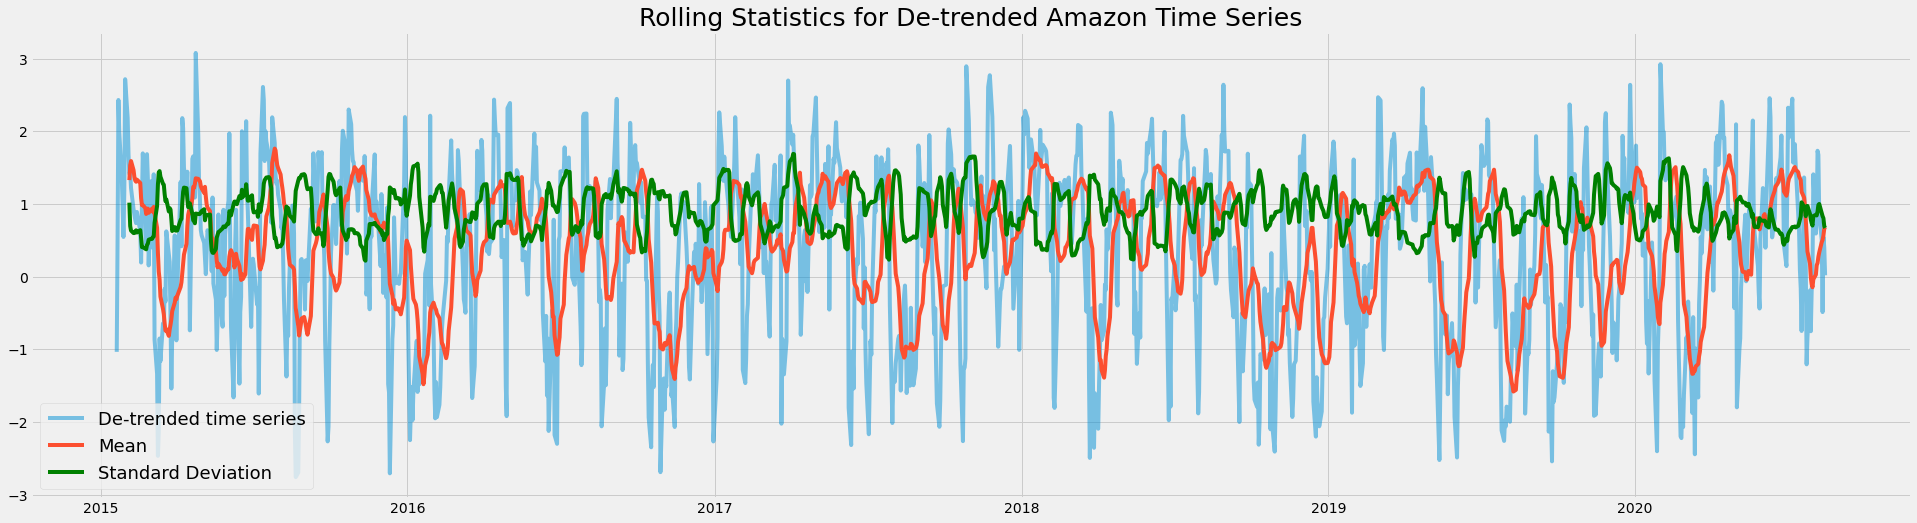

In [269]:
# Determining rolling statistics for de-trended data:
roll_mean_detrend = amazon_detrend.rolling(12).mean() 
roll_std_detrend = amazon_detrend.rolling(12).std()
    
# Plotting the rolling statistics on de-trended data:
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(amazon_detrend, label= 'De-trended time series', alpha=0.5)
ax.plot(roll_mean_detrend, label='Mean')
ax.plot(roll_std_detrend, label='Standard Deviation',linestyle='-', color='green')
plt.title('Rolling Statistics for De-trended Amazon Time Series', fontsize=25)
ax.legend(fontsize=18)
plt.show()

The plot above shows that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation compared to the original De-trended data.

##### Method 2 - Differencing:

This method removes the underlying seasonal or cyclical patterns in the time series.

ADF Statistic: -8.282870523683018
p-value: 4.4706630103022843e-13


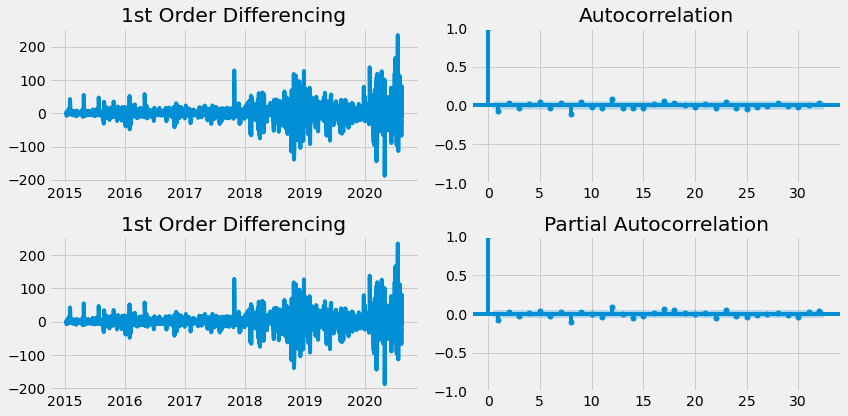

In [270]:
## First Order of Differencing -
# Taking the first order difference of Amazon stock data by  dropping the NaN values and running the ADF test again - 
# Calculating the first difference of the time series:
amazon_stationary = amazon_df['Adj Close'].diff().dropna()

# Running the ADF test on the differenced time series:
amazon_diff_1 = adfuller(amazon_stationary)

# Printing the test statistic and the p-value:
print('ADF Statistic:', amazon_diff_1[0])
print('p-value:', float(amazon_diff_1[1]))

# Plotting the ACF and PACF plots for 1st Order of Differencing of Amazon stocks:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0, 0].plot(amazon_df['Adj Close'].diff())
axes[0, 0].set_title('1st Order Differencing')
plot_acf(amazon_stationary, ax=axes[0, 1])
plot_pacf(amazon_stationary, ax=axes[1, 1])
axes[1, 0].plot(amazon_df['Adj Close'].diff())
axes[1, 0].set_title('1st Order Differencing')

plt.tight_layout()
plt.show()

ADF Statistic: -14.203422248986156
p-value: 1.7716244506837338e-26


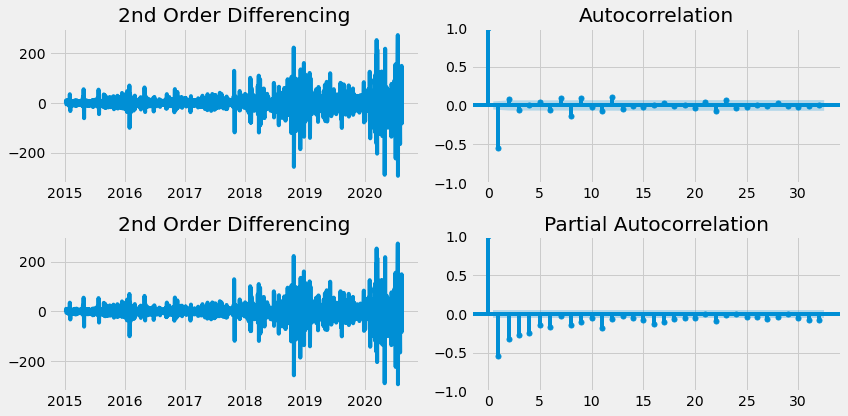

In [271]:
## Second Order of Differencing - 
# Taking the second order difference of Amazon stock data by  dropping the NaN values and running the ADF test again - 
# Calculating the second difference of the time series:
amazon_stationary_2 = amazon_df['Adj Close'].diff().diff().dropna()

# Running the ADF test on the secind differenced time series:
amazon_diff_2 = adfuller(amazon_stationary_2)

# Printing the test statistic and the p-value:
print('ADF Statistic:', amazon_diff_2[0])
print('p-value:', amazon_diff_2[1])

# Plotting the ACF and PACF plots for 2nd Order of Differencing of Amazon stocks:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0, 0].plot(amazon_df['Adj Close'].diff().diff())
axes[0, 0].set_title('2nd Order Differencing')
plot_acf(amazon_stationary_2, ax=axes[0, 1])
plot_pacf(amazon_stationary_2, ax=axes[1, 1])
axes[1, 0].plot(amazon_df['Adj Close'].diff().diff())
axes[1, 0].set_title('2nd Order Differencing')

plt.tight_layout()
plt.show()

Both the 1st Order of Differencing and 2nd Order of Differencing yield very significant p-values. For the above plots of ACF and PACF, we find that the time series reaches stationarity with two orders of differencing. But on looking at the PACF plot for the 2nd differencing the lag goes into the negative zone very quickly. This indicates that the Amazon stock series might get over-differenced with 2nd order differencing.

So, we restrict ourselves to the **order of differencing or d=1** even though the series is not perfectly stationary (weak stationarity), just to avoid over-differencing.

### Seasonal Decomposition of our Time Series - 

Every time series is a combination of 3 parts - **Trend, Seasonality and Residual**. Separating a time series into its 3 components is called decomposition of time series. 

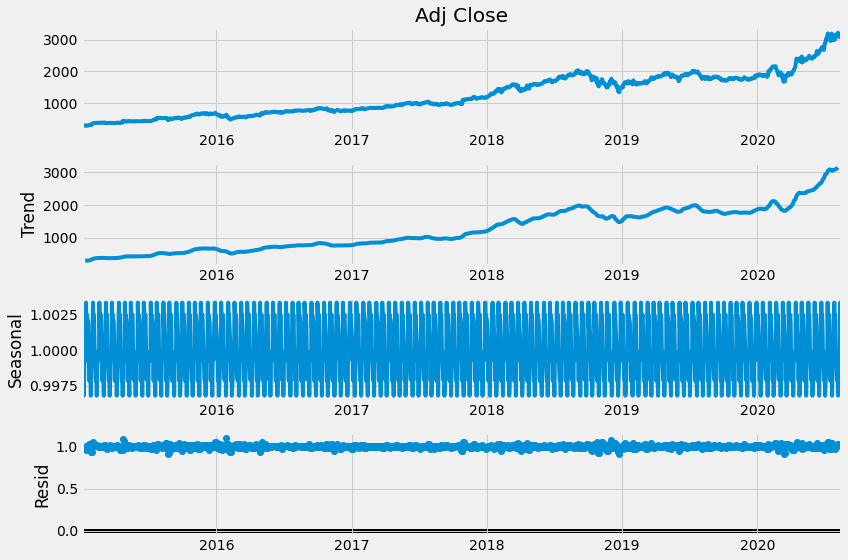

In [272]:
# Specifying the size of canvas for the plot:
plt.rc("figure", figsize=(12,8))

# Creating the multiplicative decomposition object for a period of 12:
decomposition = seasonal_decompose(amazon, model='multiplicative', period=12)

# Plotting the decomposition plot:
decomposition.plot()

plt.tight_layout()
plt.show()

We can see from the decomposition plot that our Amazon stock data has both trend and seasonality. The pattern of trend in increasing in nature however, the seasonality pattern does not appear to be very clear from this decomposition plot.

### Selection of Non-seasonal and Seasonal Orders -

####  Manual Selection of only Non-Seasonal Orders (p,d q):

First, we try to find the following non-seasonal orders manually by looping through different ranges of values for each order and fitting an ARIMA(p,d,q) model to find AIC and BIC results for each order combination.

Non-Seasonal orders:
* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.

We then find the most optimal model orders of p, d and q to be the one yielding the lowest Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values for the model.

In [273]:
# Creating an empty list to store search results:
order_aic_bic=[]

# Looping over p values from 0-2:
for p in range(3):
  # Looping over q values from 0-2:
    for q in range(3):
        for d in range(3):
            # creating and fitting to an ARMA(p,d,q) model:
            model = sm.tsa.statespace.SARIMAX(amazon_df['Adj Close'], order=(p,d,q))
            results = model.fit()
        
            # Appending the order and results tuple to a list:
            order_aic_bic.append((p, d, q, results.aic, results.bic))

# Constructing a DataFrame from order_aic_bic sorting it by the order of increasing AIC:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC']).sort_values(by='AIC')

# Printing the top 5 rows of the sorted order_df as a string:
print(order_df.head().to_string(index=False))

 p  d  q          AIC          BIC
 2  1  2 13461.423508 13487.694397
 1  2  1 13462.534189 13478.294600
 0  2  2 13462.870725 13478.631136
 1  2  2 13463.348734 13484.362616
 2  2  1 13463.910460 13484.924342


For both of these metrics a lower value suggests a better model. The difference between these two metrics is how much they penalize model complexity. 

From the results above we can identify that the **lowest AIC and BIC** values for our Amazon stock data are by setting the non-seasonal order values to **p=2, d=1 and q=2**.

#### Manual Selection of only Seasonal Orders (P,Q):

Next, we manually select the most optimal seasonal orders (P,D,Q) as specified below using the same method as for selecting non-seasonal orders.

Seasonal orders:
* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period (for S or length of the seasonal cycle)

Note - Here, we already pre-define our **length of seasonal cycle or S to 7** and **non-seasonal orders to p=2, d=1, q=2** as we found these to be most optimal through manual selection.

We also pre-specify the Seasonal order of differencing, **D = 1**.

In [274]:
# Creating an empty list to store search results:
order_aic_bic=[]

# Looping over P values from 0-2:
for P in range(3):
      # Looping over Q values from 0-2:
        for Q in range(3):
            D = 1
            p = 2
            d = 1
            q = 2
            # creating and fitting to a SARIRMA(p,d,q)(P,D,Q,S) model:
            model = sm.tsa.statespace.SARIMAX(amazon_df['Adj Close'], order=(p,q,d), seasonal_order=(P,D,Q,7))
            results = model.fit()
        
            # Appending the order and results tuple to a list:
            order_aic_bic.append((p,d,q, P, D, Q, results.aic, results.bic))

# Constructing a DataFrame from order_aic_bic sorting it by the order of increasing AIC:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','P', 'D', 'Q', 'AIC', 'BIC']).sort_values(by='AIC')

# Printing the top 5 rows of the sorted order_df as a string:
print(order_df.head().to_string(index=False))

 p  d  q  P  D  Q          AIC          BIC
 2  1  2  0  1  2 13427.361930 13458.852955
 2  1  2  2  1  1 13432.979759 13469.719288
 2  1  2  0  1  1 13433.257476 13459.499997
 2  1  2  1  1  2 13434.413699 13471.153228
 2  1  2  1  1  1 13435.162013 13466.653037


From the results above we can identify that the **lowest AIC and BIC** values for our Amazon stock data are by setting the seasonal order values to **P=0, D=1 and Q=2**.

#### Manual Selection of both Non-seasonal (p,q, d) and Seasonal (P, Q, D) Orders:

We also pre-specified both the Non-seasonal and Seasonal order of differencing, **d=1 and D = 1** and also pre-define our **length of seasonal cycle or S to 7**.

In [275]:
# Creating an empty list to store search results:
order_aic_bic=[]

# Looping over P values from 0-2:
for p in range(3):
    d = D = 1
    for q in range(3):
        for P in range(3):
          # Looping over Q values from 0-2:
            for Q in range(3):
                # creating and fitting to a SARIMA(p,d,q)(P,D,Q,S) model:
                model = sm.tsa.statespace.SARIMAX(amazon_df['Adj Close'], order=(p,q,d), seasonal_order=(P,D,Q,7))
                results = model.fit()

                # Appending the order and results tuple to a list:
                order_aic_bic.append((p,d,q, P, D, Q, results.aic, results.bic))

# Constructing a DataFrame from order_aic_bic sorting it by the order of increasing AIC:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','P', 'D', 'Q', 'AIC', 'BIC']).sort_values(by='AIC')

# Printing the top 5 rows of the sorted order_df as a string:
print(order_df.head().to_string(index=False))

 p  d  q  P  D  Q          AIC          BIC
 0  1  1  0  1  1 13417.435367 13433.183013
 1  1  1  0  1  1 13418.310466 13439.307326
 0  1  1  0  1  2 13419.425605 13440.422465
 1  1  2  2  1  1 13420.150086 13451.641111
 1  1  1  0  1  2 13420.305657 13446.551732


From the results above we can identify that the following seasonal & non-seasonal orders yielded the **lowest AIC and BIC** values for our Amazon stock data.

Non-Seasonal Order - 
* p = 0
* d = 1
* q = 1

Seasonal Orders - 
* P = 0
* D = 1 
* Q = 1

These order values were different from those we got when we selected only non-seasonal orders or seasonal orders and not both.

### Splitting the Dataset for Time Series Analysis - 

Before, fitting any models for time series analysis on our Amazon data we first split it into training an testing subsets.

In time series analysis, as we would be using past values to make future predictions hence, we would be splitting the data in relation to time i.e., training our algorithms on data coming earlier in time series and testing on data that comes later. 

In [276]:
# Splitting the Amazon Adj Close price column into training and testing sets with ratio 80:20 - 
df_train = amazon_df['Adj Close'][:int(0.8*(len(amazon_df['Adj Close'])))] 
df_test = amazon_df['Adj Close'][int(0.8*(len(amazon_df['Adj Close']))):]

# checking the size of 2 subsets:
df_train.shape, df_test.shape

((1132,), (283,))

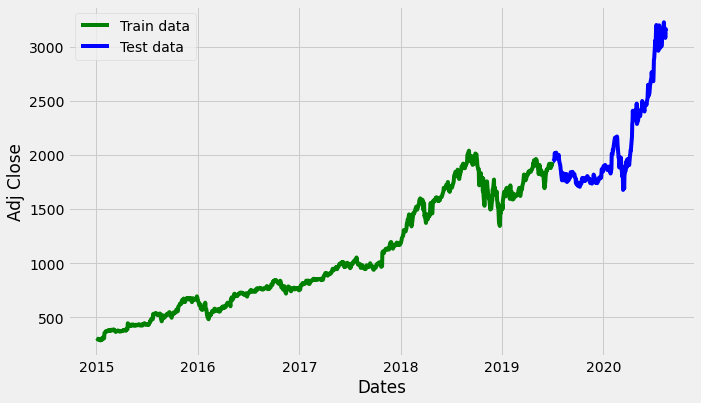

In [277]:
# Plotting the data subsets as a line plot:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adj Close')
plt.plot(df_train, 'green', label='Train data')
plt.plot(df_test, 'blue', label='Test data')
plt.legend()
plt.show()

### Model Selection for Stock Predictions -

For analyzing Amazon stock time series I used the following Time Series Analysis techniques. Each of the algorithms used would be evaluated and interpreted based on the model **Summary Results** and **Plot diagnostics**.

#### Model 1 - Autoregressive Integrated Moving Average (ARIMA) Model - 

ARIMA model has three model orders - p the autoregressive order; d the order of differencing; and q the moving average order.

Manual selection of model orders on Amazon time series yielded lowest AIC and BIC values by setting the non-seasonal order values to **p=2, d=1 and q=2**. These will be used here to fit an ARIMA(2,1,2) model on our dataset.

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1132
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5089.668
Date:                Mon, 31 Jan 2022   AIC                          10189.335
Time:                        13:13:37   BIC                          10214.490
Sample:                             0   HQIC                         10198.838
                               - 1132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0774      0.005    218.412      0.000       1.068       1.087
ar.L2         -0.9934      0.005   -199.529      0.000      -1.003      -0.984
ma.L1         -1.0917      0.008   -145.495      0.0

<Figure size 1080x432 with 0 Axes>

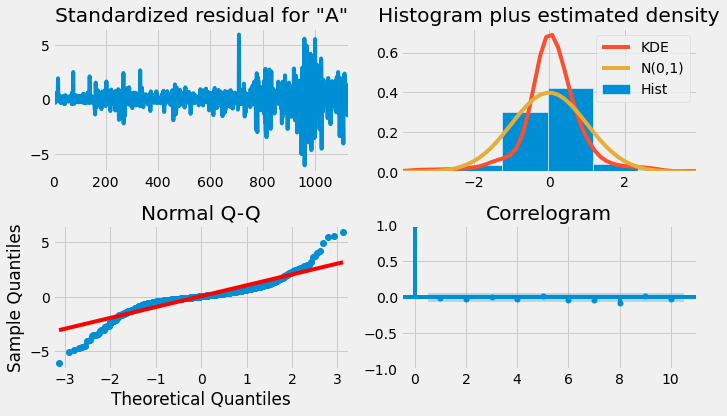

In [278]:
# Creating the ARIMA(2,1,2) model on the training subset of the Amazon time series:
model = sm.tsa.statespace.SARIMAX(df_train, order=(2,1,2))
plt.figure(figsize=(15,6))    

# Fitting the model:
results = model.fit()

# Creating the 4 standard diagnostics plots:
results.plot_diagnostics(figsize=(10,6))

# Printing the summary result for the model:
print(results.summary())

# Displaying the plot:
plt.tight_layout()
plt.show()

**4 diagnostics plots** - 
There are some obvious patterns in the residuals plot towards the right end of the plot. The KDE curve is not very similar to the normal distribution plot. Most of the data points do not lie on the red line as shown by the histogram and Q-Q plots. 
The last plot is the correlogram, which is just an ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant and they appear to be not significant here as well.

**Summary result**-
The JB p-value or Prob(JB) is zero, which means we should reject the null hypothesis that the residuals are normally distributed. 

All these 4 plots and the summary output above suggest that our ARiMA(2,1,2) model does not fit the Amazon stock data well yet.

#### Model 2 - Seasonal Autoregressive Integrated Moving-Average (SARIMA) Model 

The decomposition plot for our Amazon data suggested that there was some seasonality in the time series. This prompted us to use the SARIMA techniques next. 

SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period)


**Using Pmdarima Library** - 
Although, manual selection of orders yielded SARIMA(0,1,1)(0,1,1,7) for Amazon time series, instead of using these parameters to fit our model we would be using auto_arima function from the pmdarima package. Auto arima automatically discovers the most optimal orders for an ARIMA model.

Here, we only pre-defined the period for seasonal differencing as Daily or **m=7**.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=10193.438, Time=5.56 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10195.081, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10197.273, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10196.977, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10197.944, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=10195.255, Time=7.64 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=10193.758, Time=8.25 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=10192.735, Time=7.21 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=10194.883, Time=6.12 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=10195.237, Time=3.15 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10193.169, Time=3.42 sec
 ARIMA(2,1,2)(0,0,2)[7]             :

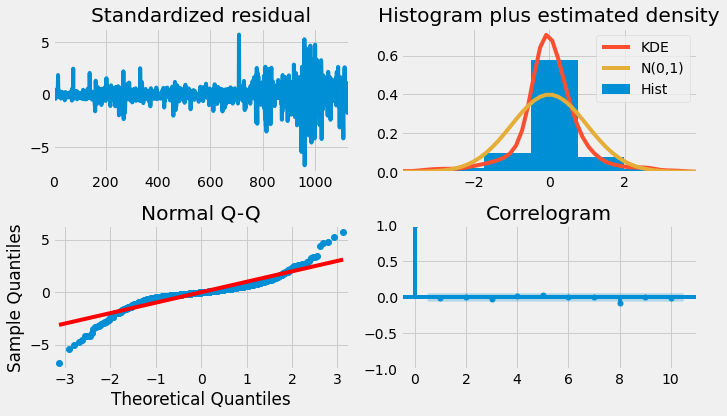

In [279]:
# Creating an auto-arima model on training set for the training subset of our Amazon stock data:
model1 = pm.auto_arima(df_train,
                       seasonal=True, m=7,   # period for seasonal differencing, m = 7 means daily recurrence 
                       test='adf',
                       max_p=2, max_q=2,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True)

# Creating the 4 standard diagnostics plots:
model1.plot_diagnostics(figsize=(10,6))

# Printing the summary result for our model:
print(model1.summary())

# Displaying the plot:
plt.tight_layout()
plt.show()

According to the summary from auto_arima, the best SARIMA model is **ARIMA(2, 1, 2)(0, 0, 2, 7)**

The summary above shows, that the model meets the condition of no correlation (independence in the residuals) because the p-value of the Ljung-Box test Prob(Q) is greater than 0.05, so we cannot reject the null hypothesis of independence.

Also, we cannot say that the residual distribution is having constant variance (homoscedastic) because the p-value of the Heteroskedasticity test Prob(H) is smaller than 0.05.

#### Making Predictions from Better Model on Unseen Data (testing subset) - 

Although, training both **ARIMA(2,1,2)** and **SARIMA(2,1,2)(0,0,2,7)** on the training subset of Amazon series yielded very similar summary results and diagnostic plots, the SARIMA model seems to be a better fit for our dataset because it has seasonal orders hence, takes into account some seasonality in our data.

Now, we would be using the **SARIMA(2,1,2)(0,0,2,7)**, fitting this model to the training set and making predictions on the testing set. 

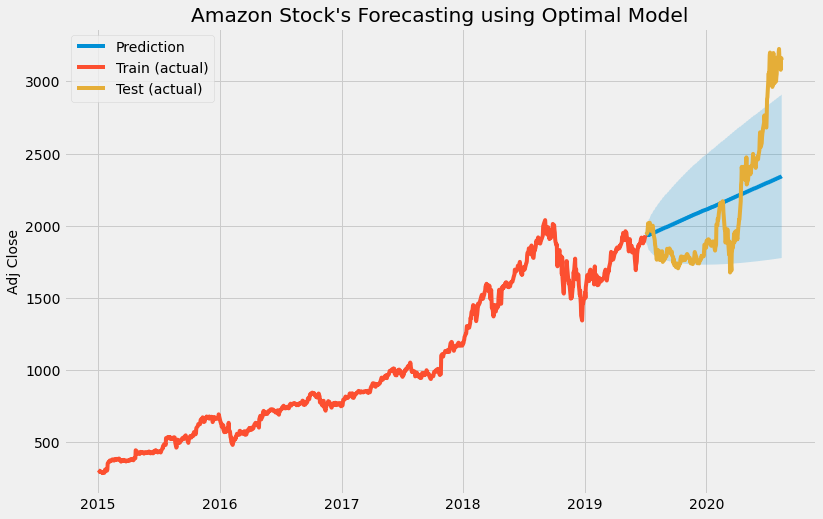

In [317]:
# Fitting the model and making predictions for the testing set time period of 283 time-periods:
model1.fit(df_train)
fc, conf_int = model1.predict(n_periods=283, return_conf_int=True)  # also getting the confidence intervals from the predictions

# Separating the confidence intervals as upper and lower limit for use in plots:
lower_limit = conf_int[:,0]
upper_limit = conf_int[:,1]

# Making a DataFrame for predictions from the model for the testing set time periods (of 283):
future_forecast = pd.DataFrame(fc, index = df_test.index, columns=['Prediction'])

# Plotting the predictions using the model and actual Stock values as per training and testing sets:
plt.plot(future_forecast, label='Prediction')
plt.plot(df_train, label='Train (actual)')
plt.plot(df_test, label='Test (actual)')

# Shading between the confidence intervals
plt.fill_between(df_test.index, lower_limit, upper_limit, alpha=0.2)

# Displaying the legend and the final plot:
plt.title("Amazon Stock's Forecasting using Optimal Model")
plt.ylabel('Adj Close', fontsize=14)
plt.legend()
plt.show()

From the above plot, we find that this model SARIMA(2,1,2)(0,0,2,7) performs only marginally well in making prediction about Amazon time series testing subset. Next, we would put this model into practice to make future or out-of-sample forecasts as well.

But before that let us evaluate the performance of our forecasting algorithm.

#### Time Series Forecasting Performance Measures - 

MAPE is the proportion of the average absolute difference between projected and true values divided by the true value. MAPE works best with data that is devoid of zeros and extreme values. The model is better if the MAPE is low. 

In [314]:
# Mean Absolute Percentage Error - 
mape = metrics.mean_absolute_percentage_error(df_test, future_forecast)
print('MAPE: %.4f' % mape)

MAPE: 0.1292


From the results of 12.9% MAPE, we can imply that our optimal SARIMA model is about 87.1% accurate in predicting the test set observations.

In [305]:
# Mean Forecast Error (or Forecast Bias) - 
forecast_errors = [df_test[i] - future_forecast['Prediction'][i] for i in range(len(df_test))]
bias = sum(forecast_errors) * 1.0/len(df_test)
print('Bias: %f' % bias)

Bias: -18.939696


In this case the result is negative, meaning that we have over-forecasted.

### Time Series Forecasting -

Time series forecasting is the use of a model to predict future values based on previously observed values.

Here, we would be making the following forecasts using our most optimal **SARIMA(2,1,2)(0,0,2,7)** model on Amazon time series.

#### Generating In-Sample (One-Step Ahead) Predictions:

In [188]:
# Assigning our most optimal model SARIMA(2,1,2)(0,0,2,7) to a variable:
model = sm.tsa.statespace.SARIMAX(df_train, order=(2,1,2), seasonal_order=(0,0,2,7))
best_results =  model.fit()
best_results

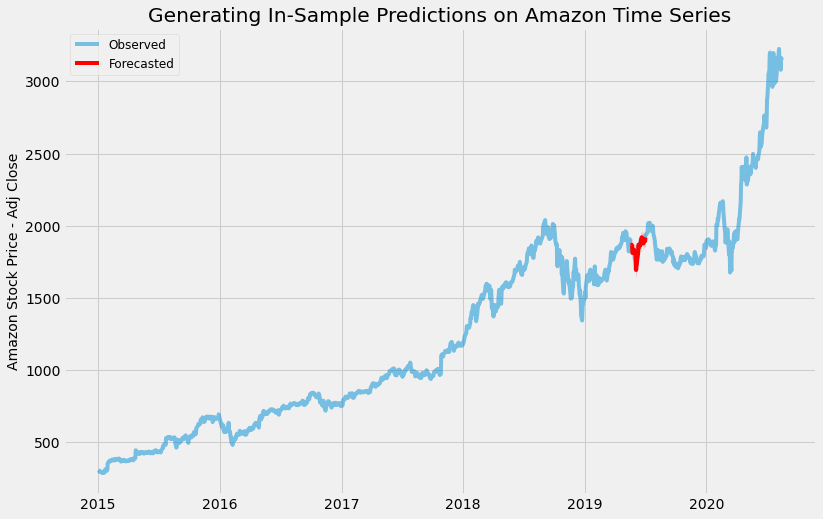

In [195]:
# Using the model_fit object to make one-step-ahead predictions over the last 30 days -
# setting the start parameter as a negative integer stating how many steps back to begin the forecast
one_step_forecast = best_results.get_prediction(start=-30) 

# Extracting mean predictions or central value of the forecast and storing it in predicted_mean attribute of forecast object:
mean_forecast = one_step_forecast.predicted_mean

# Getting the confidence intervals of predictions:
confidence_intervals = one_step_forecast.conf_int()

# Selecting lower and upper confidence limits:
# generating a pandas DataFrame of the lower and upper uncertainty range of our predictions
lower_limits = confidence_intervals.loc[:,'lower Adj Close']
upper_limits = confidence_intervals.loc[:,'upper Adj Close']

# Plotting One-Step Ahead Predictions - 
# plotting the actual Amazon stock data:
plt.plot(amazon_df['Adj Close'].index, amazon_df['Adj Close'], label='Observed',alpha=0.5)

# plotting the mean predictions for the stock:
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecasted')

# shading the area between confidence limits:
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# setting the labels, legends and displaying the plot:
plt.ylabel('Amazon Stock Price - Adj Close', fontsize=14)
plt.title('Generating In-Sample Predictions on Amazon Time Series')
plt.legend(fontsize=12)
plt.show()

In the above plot we try to make one-step ahead or in-sample predictions by training our most optimal model on training subset. We make predictions over the last 30 days after the training subset, i.e. into the testing subset.

This forecasted data is shown in red in the above plot. The actual or observed values have been made lighter by the use of ***alpha*** parameter. It appears that our forecasted values align quite well with the observed ones.

#### Generating Dynamic Forecasts: 

To make these dynamic predictions we predict one step ahead, and use this predicted value to forecast the next value after that and so on. However, as we are unaware about the shock term our uncertainty can grow very quickly at each step.

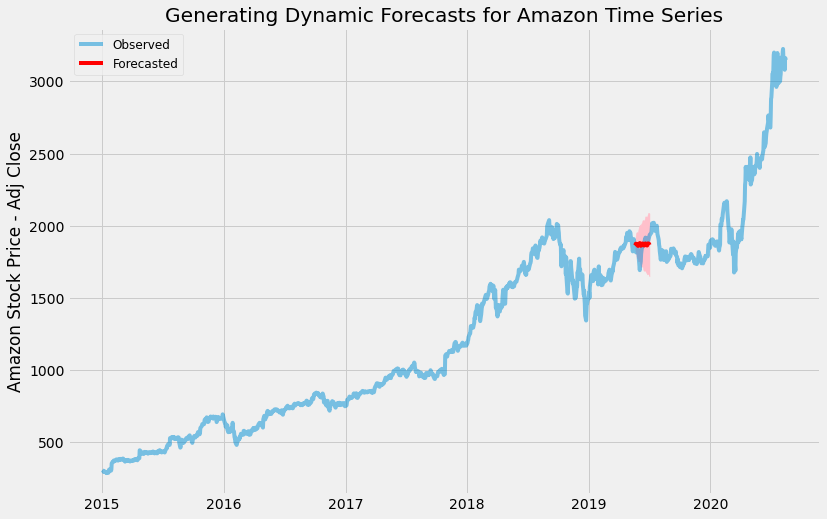

In [198]:
# Making dynamic predictions for the last 30 days:
dynamic_forecast = best_results.get_prediction(start=-30, dynamic=True)   # setting the parameter dynamic equals true

# Extracting the central value of forecast and storing it in predicted_mean attribute of forecast object:
mean_forecast = dynamic_forecast.predicted_mean

# Getting the confidence intervals of predictions:
confidence_intervals = dynamic_forecast.conf_int()

# Selecting the lower and upper confidence limits: 
lower_limits = confidence_intervals.loc[:,'lower Adj Close']
upper_limits = confidence_intervals.loc[:,'upper Adj Close']

# Plotting Dynamic Forecasts - 
# plot the actual Amazon stock data:
plt.plot(amazon_df['Adj Close'].index, amazon_df['Adj Close'], label='Observed', alpha=0.5)

# plotting the mean forecast for the stock:
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecasted')

# shading the area between confidence limits:
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# setting the labels, legends and displaying the plot:
plt.ylabel('Amazon Stock Price - Adj Close')
plt.title('Generating Dynamic Forecasts for Amazon Time Series')
plt.legend(fontsize=12)
plt.show()

Here also the dynamic forecasts are shown in red in the above plot. The actual or observed values have been made lighter by the use of ***alpha*** parameter. It appears that our dynamic forecast do not align very well with the observed ones but are reasonably fine.

#### Making Out-of-Sample Forecasts for Amazon stocks - 

Finally, after testing our predictions in-sample, we can use our model to predict the future. To make future forecasts we use the **get_forecast method** of the results object. We choose the number of steps after the end of the training data to forecast for the future.

Here, we choose 182 days or around 6-months into the future for forecasts.

In [199]:
## Making forecasts of Amazon Adjusted Close price data for the next 182 steps or approx. 6 months - 
# creating the model object, using our best model - SARIMA(2,1,2)(0,0,2)[7]:
model = SARIMAX(amazon, 
                order=(2,1,2), 
                seasonal_order=(0,0,2,7))

# Fitting the best model:
best_results = model.fit()

# Creating a forecast object to make future forecasts:
forecast_object = best_results.get_forecast(steps=182)

# Extracting the predicted mean attribute:
mean = forecast_object.predicted_mean

# Calculating the confidence intervals:
conf_int = forecast_object.conf_int()

# Extracting the forecasting indices based on days specified in steps parameter for model:
base = amazon.index[-1]
date_list = [base + datetime.timedelta(days=x) for x in range(182)]   # range must equal steps paramater value

In [209]:
# Printing the range of predicted values as confidence intervals: 
conf_int

,lower Adj Close,upper Adj Close
1415,3084.609101,3194.504505
1416,3071.848781,3222.790558
1417,3046.162227,3232.629076
1418,3027.091715,3241.214606
1419,3021.021049,3260.316688
...,...,...
1592,2486.589822,3784.075762
1593,2484.777314,3785.845436
1594,2483.008726,3787.648332
1595,2481.218307,3789.420380


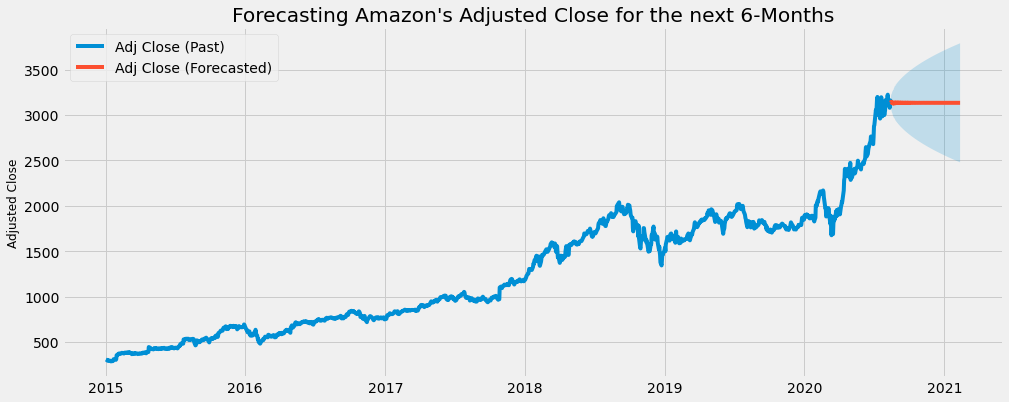

In [210]:
# Extracting the forecast dates:
# Plotting the past Amazon Adj Close prices:
plt.figure(figsize=(15,6))

plt.plot(amazon.index, amazon, label='Adj Close (Past)')

# Plotting the prediction means as line:
plt.plot(date_list, mean, label='Adj Close (Forecasted)')

# Shading between the confidence intervals
plt.fill_between(date_list, conf_int.iloc[:,0],conf_int.iloc[:,1], alpha=0.2)

# Adding a title and axes labels to the plot:
plt.title("Forecasting Amazon's Adjusted Close for the next 6-Months")
plt.ylabel('Adjusted Close', fontsize=12)

# Plotting the legend and showing the figure:
plt.legend(loc='upper left')
plt.show()

The plot in red above shows the Forecasted Adjusted Closing price for Amazon stock in the **next 6 months or 182 time-periods** into the future. It appears that the price would be fairly high in future also as shown by the shaded area of confidence intervals.